# EDA on WNC "full version"

In [23]:
from src.data_utils import (
    build_hf_dataset,
    remove_duplicate_by_revid,
    plot_length_dist_bysplit,
    plot_length_delta_bysplit,
    get_descriptive_stats,
)

# %load_ext lab_black

## Prepare

### Load data and create splits

In [3]:
DATA_PATH = "/home/cdsw/data/raw/bias_data/WNC"

wnc_datasets = build_hf_dataset(DATA_PATH, one_word=False)

181496it [00:03, 59987.13it/s]


In [4]:
wnc_datasets

DatasetDict({
    train: Dataset({
        features: ['rev_id', 'translation'],
        num_rows: 163346
    })
    test: Dataset({
        features: ['rev_id', 'translation'],
        num_rows: 9075
    })
    dev: Dataset({
        features: ['rev_id', 'translation'],
        num_rows: 9075
    })
})

### Remove duplicates

In [5]:
wnc_datasets = remove_duplicate_by_revid(wnc_datasets)

4700 duplicate records have been removed.


  0%|          | 0/164 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [6]:
wnc_datasets

DatasetDict({
    train: Dataset({
        features: ['rev_id', 'translation'],
        num_rows: 159228
    })
    test: Dataset({
        features: ['rev_id', 'translation'],
        num_rows: 8835
    })
    dev: Dataset({
        features: ['rev_id', 'translation'],
        num_rows: 8862
    })
})

## Explore

### Look at some random samples

In [12]:
random_sample = wnc_datasets["train"].shuffle(seed=45).select(range(25))

In [13]:
import pandas as pd

def inspect_df(wnc_dataset_df: pd.DataFrame):

    for rev_id in set(wnc_dataset_df["rev_id"]):
        print(rev_id)
        print()
        temp_df = wnc_dataset_df[
            wnc_dataset_df.rev_id == str(rev_id)
        ]  ## this is for duplicate inspection later on
        for i, row in temp_df.iterrows():
            print(i)
            print("PRE: ", row["translation"]["pre"])
            print("POST: ", row["translation"]["post"])
            print()

        print("-------------------------------")
        print()

In [14]:
inspect_df(random_sample.to_pandas())

4038764

17
PRE:  the pale or the english pale comprised a region in a radius of 20 miles around dublin which the english in ireland gradually fortified against the wildness of gaelic ireland.
POST:  the pale or the english pale comprised a region in a radius of 20 miles around dublin which the english in ireland gradually fortified against incursion from gaelic ireland.

-------------------------------

60993915

21
PRE:  the leela group has commissioned a 1.37 lakh sq ft state of the art building.
POST:  the leela group has commissioned a 1.37 lakh sq ft building.

-------------------------------

59552927

12
PRE:  }}north korea, officially the democratic people's republic of korea, is an east asian state occupying the northern half of the korean peninsula.
POST:  }}north korea, officially the democratic people's republic of korea, is an east asian country occupying the northern half of the korean peninsula.

-------------------------------

140321245

22
PRE:  googlezon is the name

### Descriptive stats

In [15]:
# create new dataset with calculated column lengths
wnc_datasets = wnc_datasets.map(
    lambda example: {
        "length_pre": len(example["translation"]["pre"].split()),
        "length_post": len(example["translation"]["post"].split()),
    }
).map(lambda example: {"length_delta": example["length_post"] - example["length_pre"]})

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

#### Plot text length distribution by split

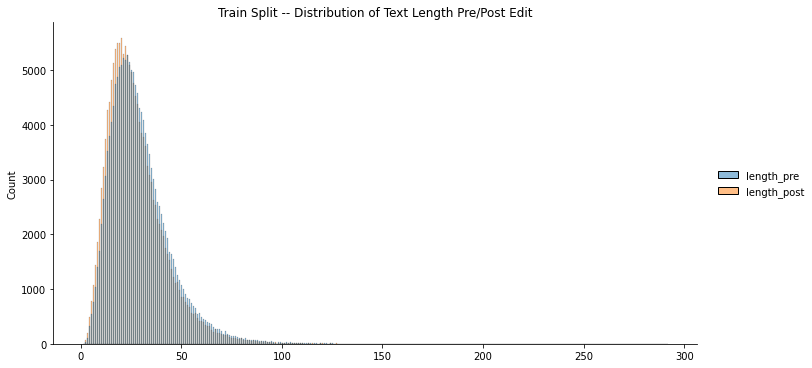

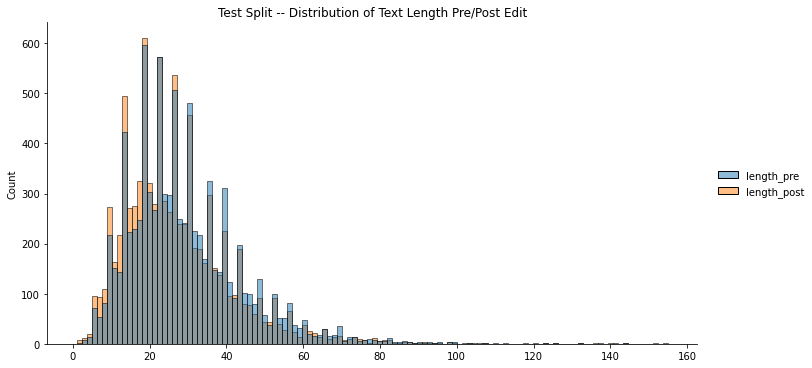

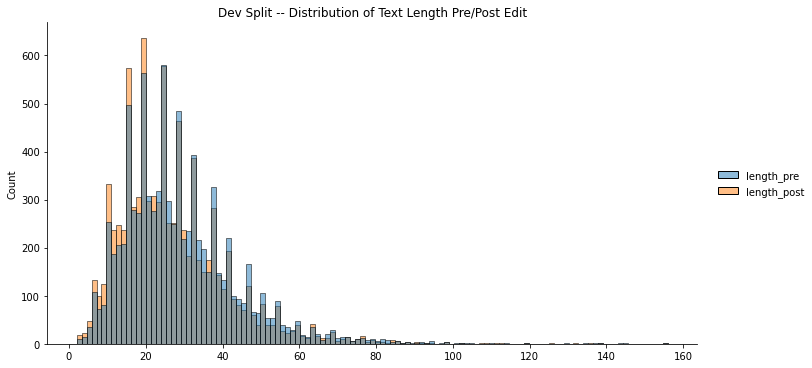

In [16]:
plot_length_dist_bysplit(wnc_datasets)

In [17]:
get_descriptive_stats(wnc_datasets)

dev                   test                  train           
      length_post length_pre length_post length_pre length_post length_pre
count     8862.00    8862.00     8835.00    8835.00   159228.00  159228.00
mean        27.00      28.83       27.11      29.10       27.32      29.23
std         14.28      14.76       14.36      14.94       14.71      15.27
min          2.00       2.00        1.00       2.00        1.00       2.00
25%         17.00      18.00       17.00      19.00       17.00      19.00
50%         24.00      26.00       24.00      26.00       24.00      26.00
75%         34.00      36.00       34.00      37.00       34.00      37.00
max        156.00     156.00      152.00     155.00      287.00     292.00

In [18]:
wnc_datasets["train"].to_pandas()["length_pre"].quantile(q=[0.01, 0.99])

0.01     6.0
0.99    79.0
Name: length_pre, dtype: float64

**NOTE:** Similar to the one-word version, let's exclude records where the pre-edit text length is outside the 1st or 99th percentile

In [19]:
lower_length, upper_length = (
        wnc_datasets["train"].to_pandas()["length_pre"].quantile(q=[0.01, 0.99])
    )

print(f'Lower: {lower_length} | Upper: {upper_length}')

wnc_datasets = wnc_datasets.filter(
    lambda example: example["length_pre"] <= upper_length
    and example["length_pre"] >= lower_length
)

Lower: 6.0 | Upper: 79.0


  0%|          | 0/160 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

#### Distribution by change in text length

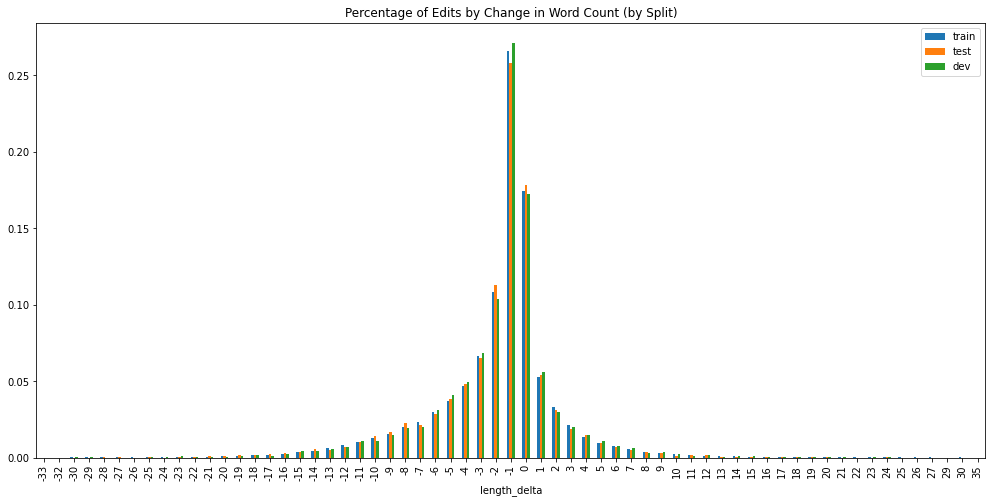

In [24]:
plot_length_delta_bysplit(wnc_datasets)

**Observations:**
- Roughly 25% of all edits on the full dataset are 1 word removals
- 15% are net even replacements
- It's odd to me that we'd have extreme additons or subtractions for NPOV related edits... lets investigate

##### Minor subtractive

In [ ]:
min_s = wnc_datasets.filter(
    lambda example: example["length_delta"] in [-6, -5, -4]
)

In [ ]:
min_s["train"]['translation'][3]

In [ ]:
min_s["train"]['translation'][4]

In [ ]:
min_s["train"]['translation'][58]

In [ ]:
min_s["train"]['translation'][101]

##### Moderate subtractive

In [ ]:
mod_s = wnc_datasets.filter(
    lambda example: example["length_delta"] in [-13, -10, -9]
)

In [ ]:
mod_s["train"]['translation'][4]

In [ ]:
# GOOD example of removing subjective claim
mod_s["train"]['translation'][8]

In [ ]:
mod_s["train"]['translation'][22]

##### Extreme subtractive

In [ ]:
ex_s = wnc_datasets.filter(
    lambda example: example["length_delta"] in [-33, -30, -25]
)

In [ ]:
# BAD example of removing seemingly disparate sentence without NPOV
ex_s["train"]['translation'][3]

In [ ]:
# BAD example of removing seemingly disparate sentence without NPOV
ex_s["train"]['translation'][4]

In [ ]:
ex_s["train"]['translation'][7]

In [ ]:
ex_s["train"]['translation'][20]

In [ ]:
ex_s["train"]['translation'][15]

In [ ]:
ex_s["train"]['translation'][18]

##### Moderate additive


In [ ]:
mod_a = wnc_datasets.filter(
    lambda example: example["length_delta"] in [13, 10, 9]
)

In [ ]:
# Example of factual information being introduced + punctuation inconsistency
mod_a["train"]['translation'][18]

In [ ]:
# GOOD
mod_a["train"]['translation'][79]

In [ ]:
# Example where the additive edit seems erroneous and includes context out of pre-text scope
mod_a["train"]['translation'][29]

In [ ]:
# GOOD example of neutralizing statements that presupposed truth
mod_a["train"]['translation'][42]

##### Extreme additive

In [ ]:
ex_a = wnc_datasets.filter(
    lambda example: example["length_delta"] in [23, 25, 26]
)

In [ ]:
ex_a["train"]['translation'][1]

In [ ]:
## BAD example where additional sentence is added randomly
ex_a["train"]['translation'][8]

**Observations:**
- On either extreme, it seems there are some "erroneous" edits where an additional sentence is added or subtracted that only makes sense in the broader paragraph context that we cannot determine from just the context provided here. Therefore these are not realistic for our model to learn/produce.
    - ex_a["train"]['translation'][8]
    - mod_a["train"]['translation'][29]  [TO SHOW]
    - ex_s["train"]['translation'][4]
    - ex_s["train"]['translation'][3]  [TO SHOW]
- It appears that some examples do introduce new factual information. This is something we cannot expect our model to account for and have no way of isolating or quantifying the extent of this type of edit. Ideally we would remove.
    - mod_a["train"]['translation'][18]  [TO SHOW]
- There are lots of multi-word edits that seem reasonable and expected under NPOV
    - mod_a["train"]['translation'][42] (presupposing truth)  [TO SHOW]
    - mod_s["train"]['translation'][8] (removes subjective claim)  [TO SHOW]
    - mod_a["train"]['translation'][79] (changing opinion stated as fact)
- These multiword edits can be complicated -- rearanging sentence structure all together. For that reason, the previous idea that simple hueristics for evalution (i.e. did we delete/replace the right word?) are not feasible. For this version of the problem, we'll need to default to some traditional measure of semantic preservation...
    
    
**Actions:**
- We cannot account for all issues that are inherent in the data. For now, let's remove extreme additive/subtractive records as defined by length_delta above or below 1st or 99th percentile

In [ ]:
wnc_datasets["train"].to_pandas()["length_delta"].quantile(q=[0.01, 0.99])

In [ ]:
subtractive_bound, additive_bound = wnc_datasets["train"].to_pandas()["length_delta"].quantile(q=[0.01, 0.99])


print(f'subtractive_bound: {subtractive_bound} | additive_bound: {additive_bound}')

wnc_datasets = wnc_datasets.filter(
    lambda example: example["length_delta"] >= subtractive_bound
        and example["length_delta"] <= additive_bound
)

In [ ]:
plot_length_delta_bysplit(wnc_datasets)

### Look at short examples

In [25]:
wnc_datasets

DatasetDict({
    train: Dataset({
        features: ['rev_id', 'translation', 'length_pre', 'length_post', 'length_delta'],
        num_rows: 156662
    })
    test: Dataset({
        features: ['rev_id', 'translation', 'length_pre', 'length_post', 'length_delta'],
        num_rows: 8711
    })
    dev: Dataset({
        features: ['rev_id', 'translation', 'length_pre', 'length_post', 'length_delta'],
        num_rows: 8733
    })
})

In [26]:
wnc_datasets_short = wnc_datasets.filter(
    lambda example: example["length_pre"] <= 30
)

  0%|          | 0/157 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

In [27]:
test = wnc_datasets_short["train"].shuffle(seed=45).select(range(50))
inspect_df(test.to_pandas())

93863982

0
PRE:  irreducible complexity is the discredited argument that certain biological systems are absolutely too complex to have evolved naturally from simpler, or "less complete" predecessors.
POST:  irreducible complexity is the position that certain biological systems are absolutely too complex to have evolved naturally from simpler, or "less complete" predecessors.

-------------------------------

102021918

30
PRE:  of the three girls, rose is the youngest and describes as a "pixyish girl-next-door" , seems to get the most male attention .
POST:  of the three girls, rose is the youngest and describes as a "pixyish girl-next-door".

-------------------------------

3650259

16
PRE:  supposed finds of chemical weapons since 2003
POST:  finds of chemical weapons since 2003

-------------------------------

159892714

18
PRE:  on 21st september 2007 he kicked the vital drop goal to give wigan a 31-30 vistory in a paly off victory at bradford.
POST:  on 21st september 2007 he k